tracking method :  < cv2.legacy.TrackerCSRT 000001426FBFBF30>
time :  31.230477571487427
number of frame to track(gt) :  451
number of frame to track(track success) :  234
Toplam Hata :  95611.12926867131


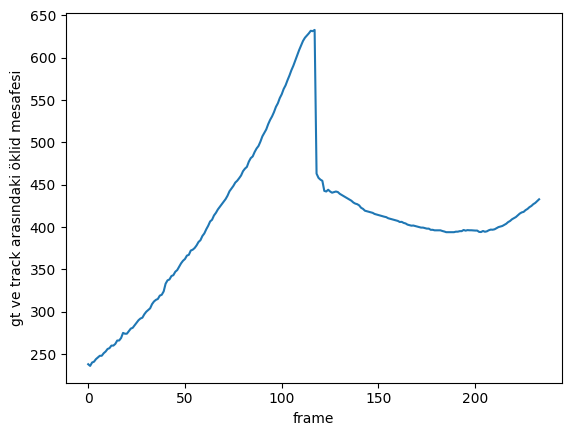

In [1]:
import cv2  #gerekli kütüphanelerimizi (paketleri) tanımlıyoruz
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd 

OPENCV_OBJECT_TRACKERS = {'csrt'       : cv2.legacy.TrackerCSRT_create,   #takip algoritmalarımızı tanımladık (en iyi algoritma 'csrt' )
                          'kcf'         : cv2.legacy.TrackerKCF_create,
                          'boosting'    : cv2.legacy.TrackerBoosting_create,
                          'mil'         : cv2.legacy.TrackerMIL_create,
                          'tld'         : cv2.legacy.TrackerTLD_create,
                          'medianflow'  : cv2.legacy.TrackerMedianFlow_create,
                          'mosse'       : cv2.legacy.TrackerMOSSE_create}


tracker_name = 'csrt' #takip algoritmamızı belirliyoruz
tracker = OPENCV_OBJECT_TRACKERS[tracker_name]() 

gt = pd.read_csv('gt_new.txt')  #ground truth dosyamızı içe aktarıyoruz

video_path = 'deneme.mp4' #video pathini veriyoruz

cap = cv2.VideoCapture(video_path) 

#genel parametreler 
initBB = None
fps = 25
frame_number = []
f = 0
success_track_frame_success = 0
track_list = []
start_time = time.time()

while True:  #sonsuz bir döngü başlatıyoruz
    time.sleep(2/75) #videomuzu yavaşlatıyoruz
    ret,frame = cap.read()  #framelerimizi okuyoruz

    if ret == False: #eğer ki framelerimizi okuyamazsak döngüyü kırıyoruz
        break

    frame = cv2.resize(frame,(960,540)) #framelerimizi yeniden boyutlandırıyoruz
    (H,W) = frame.shape[:2]  #framelerin height ve width değerlerini alıyoruz

    #gt
    car_gt = gt[gt.frame_no == f] #nesnenin gerçek bounding box'ı için gt ile nesnenin x,y,w,h değerlerini alıyoruz
    if len(car_gt) != 0:
        x = car_gt.x.values[0]
        y = car_gt.y.values[0]
        w = car_gt.w.values[0]
        h = car_gt.h.values[0]

        center_x = car_gt.center_x.values[0]  #nesnenin merkez x ve merkez y noktasını alıyoruz
        center_y = car_gt.center_y.values[0]

        cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2) # yukardan aldığımız değerler ile yeşil bir dikdörtgen çiziyoruz
        cv2.circle(frame,(center_x,center_y),2,(0,0,255),-1) #nesnenin merkezine kırmızı bir içi dolu çember çiziyoruz
    if initBB is not None: #eğer ki 't' tuşuna basılıp bir alan belirlenmişse
        (success, box) = tracker.update(frame) 
        
        if f <=np.max(gt.frame_no): 
            
            (x,y,w,h) = [int(i) for i in box] # # sınırlayıcı kutunun koordinatlarını alıyoruz
            cv2.rectangle(frame,(x,y),(x+w,y+h),(0,0,255),2) #bu koordinatlara kırmızı bir dikdörtgen çiziyoruz
            success_track_frame_success += 1 # takip edilen kare başarılı sayacını artır
            
            track_center_x  = int(x+w/2) #takip edilen nesnenin merkez koordinatlarını hesaplıyoruz
            track_center_y  = int(y+h/2)
            track_list.append([f,track_center_x,track_center_y]) #frame numarası ve merkez koordinatları karşılaştırma yapmak için listeye ekliyoruz
        
        info = [('tracker',tracker_name), #seçtiğimiz algoritmayı ve başarı bilgisi yazdırmak için info oluşturuyoruz
                ('success','yes' if success else 'no')]
        
        for (i,(o,p)) in enumerate(info): #info değişkeninden gelen bilgileri frameler üstüne yazdırıyoruz
            text = "{}: {}".format(o,p)
            cv2.putText(frame,text,(10,H-(i*20)-10),cv2.FONT_HERSHEY_SIMPLEX,0.6,(0,0,255),2)
    cv2.putText(frame,"Frame Num : "+str(f),(10,30),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255),2) #frame numarasını frame üstüne yazdırıyoruz
    cv2.imshow('frame',frame) #ve frameleri imshowluyoruz
    
    #frame
    f +=1
    frame_number.append(f)

    if cv2.waitKey(1) == ord('t'): # eğer 't' tuşuna basılırsa 
        initBB = cv2.selectROI("frame",frame,fromCenter=False) #frame üstünden bir nesne seç ve 
        tracker.init(frame,initBB) #seçilen bölgeyi izlemek için bir takipçi başlat


    if cv2.waitKey(1) == ord('q'): #eğer 'q' tuşuna basılırsa döngüyü kır
        break
 
cap.release() #görüntüyü serbest bırak
cv2.destroyAllWindows() #tüm pencereleri kapat  

stop_time = time.time() #aradaki zaman farkını buluyoruz
time_diff = stop_time - start_time

track_df =pd.DataFrame(track_list,columns=['frame_no','center_x','center_y']) 

if len(track_df) != 0:  #eğer ki track_df boş değilse 
    print('tracking method : ',tracker)  #gerekli bilgileri printliyoruz
    print('time : ',time_diff)
    print('number of frame to track(gt) : ',len(gt))
    print('number of frame to track(track success) : ',success_track_frame_success)
    track_df_frame = track_df.frame_no

    gt_center_x = gt.center_x[track_df_frame].values #graund truths ve track karşılaştırılması
    gt_center_y = gt.center_y[track_df_frame].values

    track_df_center_x = track_df.center_x.values
    track_df_center_y = track_df.center_y.values

    plt.plot(np.sqrt((gt_center_x-track_df_center_x)**2 +(gt_center_y-track_df_center_y)**2)) 
    plt.xlabel('frame')
    plt.ylabel('gt ve track arasındaki öklid mesafesi')
    error = np.sum(np.sqrt((gt_center_x-track_df_center_x)**2 +(gt_center_y-track_df_center_y)**2))  #toplam hatayı hesaplıyoruz
    print('Toplam Hata : ',error)
    